# Transmissibility of different variants in Chile

We want to infer the difference of transmissibility of the different variants currently circulating in Chile. Please have at least a short look into our publication before continuing!

## Imports

Make sure to install our 
`covid19_inference` package or inititialize the
submodules `git submodule update --init`!

In [1]:
import sys
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter,WeekdayLocator
import pickle
import os
import arviz as az

sys.path.append("./covid19_inference")
import covid19_inference as cov19

Additionaly we set some environmental variables here, make sure to set `n_processes` according to the cores of your machine.

In [2]:
n_threads = str(1) # per process
n_processes = 8

os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

### Preprocess data

We start by loading the variant data for chile i.e. $y_{v,t}$ and $n_{v,t}$. The resolution for the data is weekly, starting on mondays.

In [3]:
data_end = datetime.datetime(2021,7,24)

# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_with_airports.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1"]

Additionaly we download the new confirmed cases in chile with our previous developed download utils. You can find the documentation for the data retrieval module [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).

In [4]:
# Load casenumbers chile and sum over weeks
jhu = cov19.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(
    country="Chile",
    data_begin=variants.index[0], #starting with the same date as the variant data
    data_end=data_end
)
jhu.download_all_available_data(force_download=True)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


Let us take a short look into the data. We plot the total number of sampled pcr test such as the number of test which could be per variant and the reported cases in chile.

/home/sebastian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


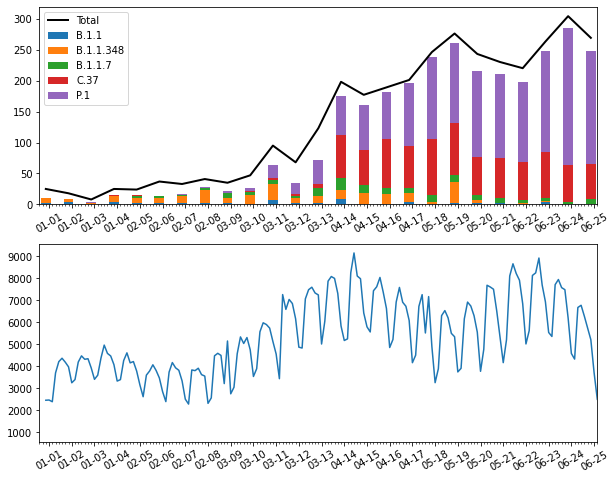

In [5]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s)
    s += variants[c]
axes[0] = cov19.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=axes[0],
    label="Total",
    lw=2
)
axes[0].legend()
axes[1] = cov19.plot._timeseries(
    x=new_cases_obs.index,
    y=new_cases_obs,
    what="model",
    color="tab:blue",
    ax=axes[1],
)

# Date layout
date_form = DateFormatter("%m-%V")

# Markup
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(variants.index[0]-datetime.timedelta(days=2), variants.index[-1]+datetime.timedelta(days=2))

## Create model

We defined different models and tested which one fits the dynamics best, have a look into `run_model.py` for more informations. For now we are running the default model with dirichlet likelihood and kernelized spread.

In [6]:
from run_model import create_model

likelihood="dirichlet"
spreading_dynamics="kernelized_spread"
influx_factor=0.2

this_model = create_model(
    likelihood=likelihood,
    spreading_dynamics=spreading_dynamics,
    variants=variants,
    new_cases_obs=new_cases_obs,
    factor_influx=influx_factor
)

INFO     [utils] pr_sigma_date_transient was set to default value 1.5
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [utils] pr_sigma_lambda was set to default value 0.2
INFO     [utils] relative_to_previous was set to default value True
INFO     [utils] pr_factor_to_previous was set to default value 1.0
INFO     [utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.model.compartmental_models] Kernelized spread with variants
INFO     [covid19_inference.model.delay] Delaying cases
WARNING  [theano.tensor.blas]

## Sampling 

We use our own sampling function which we developed for because of computation time reasons and parallization. You can also use the default `pm.sample` function which may be faster in envorionments without a lot of cores. Depending on how the draws, tune and chains it can take some time.

```python
import pymc3 as pm

trace = pm.sample(
    model=this_model,
    return_inferencedata=True,
    cores=n_processes,
    chains=4,
    draws=2000,
    tune=2000,
    init="advi+adapt_diag",
    target_accept=0.97,
)
```

In [ ]:
multitrace, trace, multitrace_tuning, trace_tuning = cov19.robust_sample(
    this_model,
    draws=1500,
    tune=600,
    tune_2nd=1200,
    tuning_chains=32,
    final_chains=16,
    return_tuning=True,
    max_treedepth=10,
    target_accept=0.8,
    cores=n_processes
)

Next we save the model and trace, such that we can reuse it at a later point in time, e.g. for the plotting script.

In [15]:
import pickle

# Save the trace (maybe we want to load it at a later point)
fstring = f"./data/pickled/Variants-likelihood={likelihood}-spread_method={spreading_dynamics}-influx={influx_factor}_forecast.pickle"
with open(fstring, 'wb') as f:
    pickle.dump((this_model,trace),f)
print(f"Saved model trace combo to: '{fstring}'")

Saved model trace combo to: './data/pickled/Variants-likelihood=dirichlet-spread_method=kernelized_spread-influx=0.2_forecast.pickle'


## Plotting and results

To recreate the exact plots from our publication please take a look into the `create_plots.ipynb` notebook. In the following we will just take a short look into the convergence and than show a simple plot for the new cases obs and the transmissibility factors $f_v$.

First let's check if the chains converged to the same values. We can do that by computing the rhat statistic, it should be around one for most variables. One can also plot the joint log posterior density for the model, most of the times the divergence of the chains is also visible by eye there. 

In [ ]:
az.rhat(trace).max()

In [ ]:
#effective sample sizes
az.ess(trace).min()

Finally let's create some plots for our results i.e. the model fits.

In [ ]:
def posterior_to_array(trace, key):
    """
    Convert posterior for a key into a numpy array. Flattens
    chain and draw dimensions in the arviz trace.
    """
    var = np.array(trace.posterior[key])
    var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    return var

model = this_model
""" Plot lambda and casenumbers
"""
fig, axes = plt.subplots(3,1,figsize=(9,7), gridspec_kw={'height_ratios': [1, 1, 2]})
date_range = pd.date_range(model.sim_begin, model.sim_end)

# Plot R if B.1.1.7 would have been dominant (or lambda depending on the model)
R = posterior_to_array(trace,"base_lambda_t")
cov19.plot._timeseries(
    x=date_range,
    y=R,
    what="model",
    ax=axes[0]
)
axes[0].set_ylabel("effective R\nif B.1.1.7 would\nhave been dominant")

# Load posterior samples from trace with the corresonding key
R = posterior_to_array(trace,"base_lambda_t")
f = posterior_to_array(trace,"f_v")
unkn = posterior_to_array(trace,"unknown_lambda_t")
new_I = posterior_to_array(trace,"new_I_tv")
S_t = posterior_to_array(trace,"S_t")

# Compute some interesting values
tau_spread = new_I/np.sum(new_I, axis=-1)[...,None]
fact = S_t/model.N_population
R_eff = np.exp(np.sum(np.log(R[:,:,None]*f[:,None,:])*fact[...,None]*tau_spread[:,:,:-1] + (np.log(unkn*R)*fact*tau_spread[:,:,-1])[:,:,None], axis=-1))

# Plot effective Reproduction number
cov19.plot._timeseries(
    x=date_range,
    y=R_eff,
    what="model",
    ax=axes[1]
)
axes[1].set_ylabel("effective R")
axes[1].plot(date_range, np.ones(len(date_range)), color='grey')

# Calculate rolling average new_cases
nc = posterior_to_array(trace,"new_cases")
nc = pd.DataFrame(nc.T,index=pd.date_range(model.sim_begin,model.sim_end))

# Plot new cases (real)
cov19.plot._timeseries(
    x=new_cases_obs.index[7:],
    y=new_cases_obs.rolling(7).mean().T[7:],
    what="data",
    ax=axes[2],
    color="black",
    markersize=4
)

# Plot new cases (model)
cov19.plot._timeseries(
    x=nc.index,
    y=nc.rolling(7).mean().T,
    what="model",
    ax=axes[2]
)
axes[2].set_ylabel("Number of cases")


for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    # exclude first 7 days because of the rolling window of cases of 7 days
    _ = ax.set_xlim(model.data_begin-datetime.timedelta(days=2), model.data_end+datetime.timedelta(days=2))
    
axes[1].set_ylim(0.5,2)
axes[2].set_ylim(0,10000)
fig.tight_layout()